In [3]:
from roboticstoolbox import DHRobot,RevoluteDH,PrismaticDH
import roboticstoolbox as rtb
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from spatialmath import *

In [4]:
from Planar3DOF import Planar3DOF
robot=Planar3DOF()
print(robot)
print(robot.links)

┌───┬───────────┬───────────┬─────────────┬───────────────────┐
│id │   link    │  parent   │    joint    │        ETS        │
├───┼───────────┼───────────┼─────────────┼───────────────────┤
│ 0 │     world │         - │             │                   │
│ 1 │ base_link │     world │       fixed │                   │
│ 2 │    link_1 │ base_link │     joint_1 │ tz(0.05) * Rz(q0) │
│ 3 │    link_2 │    link_1 │     joint_2 │ tx(0.5) * Rz(q1)  │
│ 4 │   gripper │    link_2 │     joint_3 │ tx(0.5) * Rz(q2)  │
│ 5 │      @end │   gripper │ gripper_end │ tx(0.18)          │
└───┴───────────┴───────────┴─────────────┴───────────────────┘

┌─────┬─────┬──────┬───────┐
│name │ q0  │ q1   │ q2    │
├─────┼─────┼──────┼───────┤
│  qz │  0° │  0°  │  0°   │
│  qr │  0° │  90° │ -90°  │
│  qs │  0° │  0°  │ -90°  │
│  qn │  0° │  45° │  180° │
└─────┴─────┴──────┴───────┘

[ELink(world, ets=), ELink(base_link, ets=, parent=world), ELink(link_1, ets=tz(0.05) * Rz(q), parent=base_link, qlim=[-1.57, 

[ 0.          0.         -1.57079633]


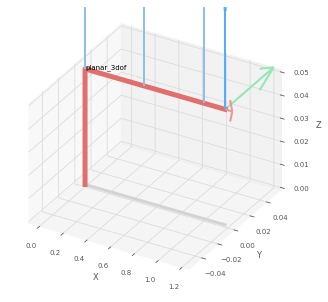

<Figure size 432x288 with 0 Axes>

In [5]:
print(robot.qs)
robot.plot(robot.qs,backend='pyplot',block=False)

## Forward and inverse kinematics


In [6]:
print(robot.qs)
T = robot.fkine(robot.qs)
T


[ 0.          0.         -1.57079633]


SE3:   0           1           0           1            
      -1           0           0          -0.18         
       0           0           1           0.05         
       0           0           0           1            
    

In [7]:
sol2=robot.ikine_LM(T,mask=[1,1,1,0,0,0])
print(sol2)
if sol2.success:
    print(robot.fkine(sol2.q))
   
else:
    print("solution not available")

IKsolution(q=array([ 0.03903782, -0.07807886, -1.52752226]), success=True, reason=None, iterations=8, residual=6.539140993047097e-12)
   0.00423301  0.999991    0           1            
  -0.999991    0.00423301  0          -0.18         
   0           0           1           0.05         
   0           0           0           1            



## Trayectories by hand

Text(0.5, 1.0, 'movimiento deseado en el plano xy del gripper')

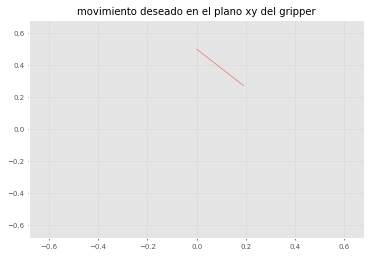

In [8]:
# perfil velocidades del gripper (la de z debe ser zero porque es un robot planar)
pp_d=np.array([0.1,-0.12,0]) #la velocidad en x,y,z del gripper
#integramos para obtener las posiciones deseadas 
n=20 # numero de pasos
Ts=0.1 # periodo de muestreo
time=np.linspace(0,n*Ts,n) # vector de tiempo


#Cambiar esta trayectoria por su inicial
p_d=np.zeros((20,len(pp_d))) # posición deseada
p_d[0,:]=np.array([0,0.5,0.05]) # posición inicial
for i in range(1,n):
    p_d[i,:]=p_d[i-1,:]+Ts*pp_d
    

plt.plot(p_d[:,0],p_d[:,1])
plt.xlim([-0.68,0.68])
plt.ylim([-0.68,0.68])
plt.title('movimiento deseado en el plano xy del gripper')
#p_d

Text(0.5, 1.0, 'angulo deseado del gripper con respecto al tiempo')

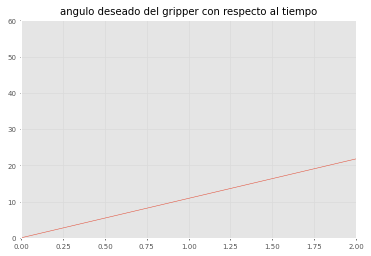

In [9]:
#perfil de orientación del gripper
thetap_d=np.array([0.2]) #velocidad angular del gripper
#integramos para obtener las posiciones deseadaas 
theta_d=np.zeros((20,len(thetap_d)))
theta_d[0,:]=np.array([0])  #el angulo inicial
for i in range(1,n):
    theta_d[i,:]=theta_d[i-1,:]+Ts*thetap_d
    
#dibujamos
plt.plot(time,theta_d[:,0]*180/pi)
plt.xlim([0,n*Ts])
plt.ylim([0,60])
plt.title('angulo deseado del gripper con respecto al tiempo')

In [10]:
#planear la posición de los motores
q_m=np.zeros((n,len(robot.q))) # posicion del motor en cada instanate de tiempo
qp_m=np.zeros((n,len(robot.q))) # velocidad del motor en cada instante de tiempo
for i in range(0,n): # recorremos los n puntos que queremos que pase el gripper
    # transformar a SE3(una rotacion en z + una translación)
    T=SE3.Rz(theta_d[i,0],unit='rad')
    T=SE3(x=p_d[i,0],y=p_d[i,1],z=p_d[i,2])*T   
    
    #try to add initial guess to increase performance
    sol2=robot.ikine_LM(T) 
    #TODO: what to do if no solution?
    if sol2.success:
        q_m[i,:]=sol2.q
        rank=np.linalg.matrix_rank(robot.jacob0(sol2.q))
        #TODO: if the rank is not three there exist a singular position
        if rank==3:
            qp_m[i,:]=np.matmul(np.linalg.pinv(robot.jacob0(sol2.q)[[0,1,-1],:]),pp_d)

Text(0.5, 1.0, 'velocidad de los motores con respecto al tiempo')

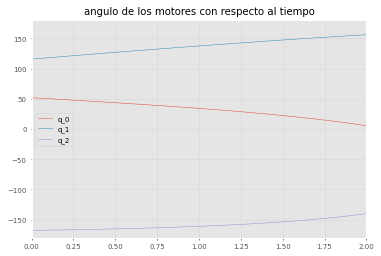

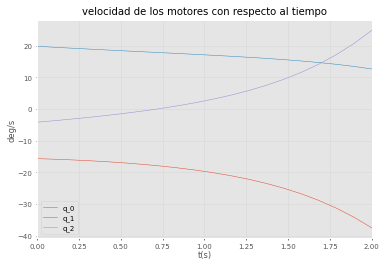

In [11]:
plt.plot(time,q_m*180/pi)
plt.xlim([0,n*Ts])
plt.ylim([-180,180])
plt.legend(['q_0','q_1','q_2'])
plt.title('angulo de los motores con respecto al tiempo')
plt.figure()
plt.plot(time,qp_m*180/pi)
plt.xlim([0,n*Ts])
#plt.ylim([-180,180])
plt.ylabel('deg/s')
plt.xlabel('t(s)')
plt.legend(['q_0','q_1','q_2'])
plt.title('velocidad de los motores con respecto al tiempo')

In [12]:
env =  rtb.backends.Swift()
env.launch()
env.add(robot)
for i in range(0,10*n):
        robot.q=q_m[i%n,:]
        env.step(Ts)
env.remove(robot)
env.close()

## Trajectories with toolbox

### trayectorias directas



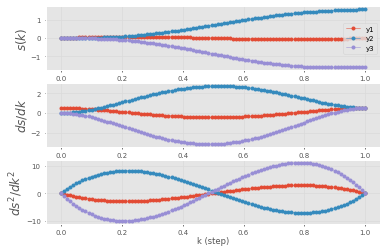

In [21]:
#trayectorias directas

traj = rtb.jtraj(robot.qz, robot.qr, 100,qd0=np.array([0.5,0,0]),qd1=np.array([0.5,0.5,0.5]))
traj.plot()

In [14]:
robot.plot(traj.y,block=False)

### Trayectoria en coordenadas cartesianas


In [15]:
T_i=SE3(x=p_d[0,0],y=p_d[0,1],z=p_d[0,2])*SE3.Rz(theta_d[0,0],unit='rad')

T_f=SE3(x=p_d[-1,0],y=p_d[-1,1],z=p_d[-1,2])*SE3.Rz(theta_d[-1,0],unit='rad')
Traj=rtb.tools.trajectory.ctraj(T_i, T_f, 20)
Traj

SE3:[0] =
       1           0           0           0            
       0           1           0           0.5          
       0           0           1           0.05         
       0           0           0           1            
    [1] =
       0.999997   -0.00236842  0           0.00118421   
       0.00236842  0.999997    0           0.498579     
       0           0           1           0.05         
       0           0           0           1            
    [2] =
       0.999955   -0.00947354  0           0.00473684   
       0.00947354  0.999955    0           0.494316     
       0           0           1           0.05         
       0           0           0           1            
    [3] =
       0.999773   -0.0213142   0           0.0106579    
       0.0213142   0.999773    0           0.487211     
       0           0           1           0.05         
       0           0           0           1            
    [4] =   0.999282   -0.0378857   0           

In [16]:
T[0].printline()
print(T[0].eul())
print(T[0].angvec())
print(UnitQuaternion(T[0].R))

t =     0.19,     0.27,     0.05; rpy/zyx =        0°,        0°,       22°
[0.   0.   0.38]
(0.3800000000000003, array([0., 0., 1.]))
 0.9820 <<  0.0000,  0.0000,  0.1889 >>


In [17]:
rtb.models.list(mtype="URDF")

┌────────┬──────────┬────────────────────┬────────────┬─────┬───────────────────────────────────────────────┬──────────┐
│ class  │  model   │    manufacturer    │ model type │ DoF │                                        config │ keywords │
├────────┼──────────┼────────────────────┼────────────┼─────┼───────────────────────────────────────────────┼──────────┤
│Panda   │ panda    │ Franka Emika       │ URDF       │ 7   │ RRRRRRR                                       │          │
│Frankie │ frankie  │ Franka Emika       │ URDF       │ 9   │ RPRRRRRRR                                     │          │
│UR3     │ ur3      │ Universal Robotics │ URDF       │ 6   │ RRRRRR                                        │          │
│UR5     │ ur5      │ Universal Robotics │ URDF       │ 6   │ RRRRRR                                        │          │
│UR10    │ ur10     │ Universal Robotics │ URDF       │ 6   │ RRRRRR                                        │          │
│Puma560 │ Puma560  │ Unimation 